In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
from typing import Tuple, Callable, List, NamedTuple
import torchvision
import tqdm

In [2]:
# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
# Si un GPU est disponible, l'utilise
# PyTorch a une façon élegante de garder le code indépendant du device
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

cuda


In [3]:
# Seed all random number generators
np.random.seed(197331)
torch.manual_seed(197331)
random.seed(197331)

In [ ]:
class NetworkConfiguration2(NamedTuple):
    n_channels: Tuple[int, ...] = (16, 32, 45)
    kernel_sizes: Tuple[int, ...] = (3, 3, 3)
    strides: Tuple[int, ...] = (1, 1, 1)
    paddings: Tuple[int, ...] = (0, 0, 0)
    dense_hiddens: Tuple[int, ...] = (256, 256)

In [94]:
class NetworkConfiguration(NamedTuple):
    n_channels: Tuple[int, ...] = (16, 32, 48)
    kernel_sizes: Tuple[int, ...] = (3, 3, 3)
    strides: Tuple[int, ...] = (1, 1, 1)
    paddings: Tuple[int, ...] = (0, 0, 0)
    dense_hiddens: Tuple[int, ...] = (256, 256)

# Pytorch preliminaries
def gradient_norm(function: Callable, *tensor_list: List[torch.Tensor]) -> float:
    return torch.stack(torch.autograd.grad(function(*tensor_list), tensor_list)).norm()


def jacobian_norm(function: Callable, input_tensor: torch.Tensor) -> float:
    return torch.autograd.functional.jacobian(function, input_tensor).norm()


# noinspection PyTypeChecker
class Trainer:
    def __init__(self,
                 network_type: str = "mlp",
                 net_config: NetworkConfiguration = NetworkConfiguration(),
                 datapath: str = './data',
                 n_classes: int = 10,
                 lr: float = 0.00000001,
                 batch_size: int = 128,
                 activation_name: str = "relu",
                 normalization: bool = True):
        self.train, self.valid, self.test = self.load_dataset(datapath)
        if normalization:
            self.train, self.valid, self.test = self.normalize(self.train, self.valid, self.test)
        self.network_type = network_type
        activation_function = self.create_activation_function(activation_name)
        input_dim = self.train[0][0].shape
        if network_type == "mlp":
            self.network = self.create_mlp(input_dim[0] * input_dim[1] * input_dim[2], net_config,
                                           n_classes, activation_function)
        elif network_type == "cnn":
            self.network = self.create_cnn(input_dim[0], net_config, n_classes, activation_function)
        else:
            raise ValueError("Network type not supported")
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=lr)
        self.datapath = datapath
        self.n_classes = n_classes
        self.lr = lr
        self.batch_size = batch_size
        self.epsilon = 1e-9

        self.train_logs = {'train_accuracy': [], 'validation_accuracy': [], 'train_loss': [], 'validation_loss': [],
                           'train_gradient_norm': []}

    @staticmethod
    def load_dataset(datapath: str) -> Tuple[
        Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]:
        trainset = torchvision.datasets.FashionMNIST(root=datapath,
                                                     download=True, train=True)
        testset = torchvision.datasets.FashionMNIST(root=datapath,
                                                    download=True, train=False)

        X_train = trainset.data.view(-1, 1, 28, 28).float()
        y_train = trainset.targets

        X_ = testset.data.view(-1, 1, 28, 28).float()
        y_ = testset.targets

        X_val = X_[:2000]
        y_val = y_[:2000]

        X_test = X_[2000:]
        y_test = y_[2000:]
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

    @staticmethod
    def create_mlp(input_dim: int, net_config: NetworkConfiguration, n_classes: int,
                   activation: torch.nn.Module) -> torch.nn.Module:
        """
        Create a multi-layer perceptron (MLP) network.

        :param input_dim: already vectorized input dimensions of one image
        :param net_config: a NetworkConfiguration named tuple. Only the field 'dense_hiddens' will be used.
        :param n_classes: The number of classes to predict.
        :param activation: The activation function to use.
        :return: A PyTorch model implementing the MLP.
        """
        # Stores the inputs/outputs of the hidden layers
        hid_sizes = net_config.dense_hiddens
        n_hidden_layers = len(hid_sizes)

        # Initiate a modules list to pass onto the sequential model
        modules = [nn.Flatten()]

        # Designs a model without hidden layers if it's the case
        if n_hidden_layers < 1:
            modules.append(nn.Linear(input_dim, n_classes))
            modules.append(nn.Softmax())
            return nn.Sequential(*modules)

        # Then we have at least 1 layer, so we build the first layer with it's activation layer
        modules.append(nn.Linear(input_dim, hid_sizes[0]))
        modules.append(activation)

        # Repeat the process for every other layer until we get to the last one
        for i in range(n_hidden_layers - 1):
            modules.append(nn.Linear(hid_sizes[i], hid_sizes[i + 1]))
            modules.append(activation)

        # Applies the last fully connected layer
        modules.append(nn.Linear(hid_sizes[-1], n_classes))
        modules.append(nn.Softmax())

        return nn.Sequential(*modules)

    @staticmethod
    def create_cnn(in_channels: int, net_config: NetworkConfiguration, n_classes: int,
                   activation: torch.nn.Module) -> torch.nn.Module:
        """
        Create a convolutional network.

        :param in_channels: The number of channels in the input image.
        :param net_config: a NetworkConfiguration specifying the architecture of the CNN.
        :param n_classes: The number of classes to predict.
        :param activation: The activation function to use.
        :return: A PyTorch model implementing the CNN.
        """
        n_channels, kernel_sizes, strides, paddings, dense_hiddens = net_config
        
        # Stores the dimensions into one tuple for a nice 'for' loop
        channels = list(n_channels)
        channels.insert(0, in_channels)
        channels = tuple(channels)
        
        # Initiate a modules list to pass onto the sequential model
        modules = []
        
        # Design the cnn layers
        if len(n_channels) > 0:
            for i in range(len(n_channels)):
                modules.append(nn.Conv2d(in_channels=channels[i], out_channels=channels[i + 1],
                                         kernel_size=kernel_sizes[i],
                                         stride=strides[i], padding=paddings[i]))
                modules.append(activation)
                if i == len(channels) - 2:
                    modules.append(nn.AdaptiveMaxPool2d((4, 4)))
                else:
                    modules.append(nn.MaxPool2d(kernel_size=2))
        
        # Flatten for fully connected layer 
        modules.append(nn.Flatten())
        
        # Designs a model without hidden layers if it's the case
        if len(dense_hiddens) < 1:
            modules.append(nn.Linear(4 * 4 * channels[-1], n_classes))
            modules.append(nn.Softmax())
            cnn = nn.Sequential(*modules)
            return cnn
        
        # Then we have at least 1 layer, so we build the first layer with it's activation layer
        modules.append(nn.Linear(4 * 4 * channels[-1], dense_hiddens[0]))
        modules.append(activation)
        
        # Repeat the process for every other layer until we get to the last one
        for i in range(len(dense_hiddens) - 1):
            modules.append(nn.Linear(dense_hiddens[i], dense_hiddens[i + 1]))
            modules.append(activation)
        
        # Applies the last fully connected layer
        modules.append(nn.Linear(dense_hiddens[-1], n_classes))
        modules.append(nn.Softmax())
        
        return nn.Sequential(*modules)

    @staticmethod
    def create_activation_function(activation_str: str) -> torch.nn.Module:
        if activation_str == "relu":
            return nn.ReLU()
        elif activation_str == "tanh":
            return nn.Tanh()
        elif activation_str == "sigmoid":
            return nn.Sigmoid()
        else:
            return nn.ReLU()

    def one_hot(self, y: torch.Tensor) -> torch.Tensor:
        return nn.functional.one_hot(y)

    def compute_loss_and_accuracy(self, X: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, float]:
        # Does the full forward calculation and stores it
        forward = self.network.forward(X)

        # Puts to 0 the probabilities less then epsilon and adds epsilon instead where it needs to
        prob_pred = forward * (forward >= self.epsilon) + (forward < self.epsilon) * self.epsilon
        # Puts to 1 the probabilities more then 1 - epsilon and adds 1 - epsilon instead where
        prob_pred *= (forward <= 1. - self.epsilon) + (forward > 1. - self.epsilon) * (1. - self.epsilon)

        # Manual compute of the cross-entropy loss
        loss = (-y * torch.log(prob_pred)).sum(1).mean(0)

        # Classic accuracy calculation
        acc = (forward.argmax(1) == y.argmax(1)).double().mean()

        return (loss, acc)

    @staticmethod
    def compute_gradient_norm(network: torch.nn.Module) -> float:
        return np.sqrt(np.sum([x.grad.data.norm() ** 2 for x in network.parameters()]))

    def training_step(self, X_batch: torch.Tensor, y_batch: torch.Tensor) -> float:
        loss = self.compute_loss_and_accuracy(X_batch, y_batch)[0]
        self.optimizer.zero_grad()
        loss.backward()
        # Calculating the norm before updating the parameters
        norm = self.compute_gradient_norm(self.network)
        self.optimizer.step()
        return norm

    def log_metrics(self, X_train: torch.Tensor, y_train_oh: torch.Tensor,
                    X_valid: torch.Tensor, y_valid_oh: torch.Tensor) -> None:
        self.network.eval()
        with torch.inference_mode():
            train_loss, train_accuracy = self.compute_loss_and_accuracy(X_train, y_train_oh)
            valid_loss, valid_accuracy = self.compute_loss_and_accuracy(X_valid, y_valid_oh)
        self.train_logs['train_accuracy'].append(train_accuracy)
        self.train_logs['validation_accuracy'].append(valid_accuracy)
        self.train_logs['train_loss'].append(float(train_loss))
        self.train_logs['validation_loss'].append(float(valid_loss))

    def train_loop(self, n_epochs: int):
        # Prepare train and validation data
        X_train, y_train = self.train
        y_train_oh = self.one_hot(y_train)
        X_valid, y_valid = self.valid
        y_valid_oh = self.one_hot(y_valid)

        n_batches = int(np.ceil(X_train.shape[0] / self.batch_size))

        self.log_metrics(X_train[:2000], y_train_oh[:2000], X_valid, y_valid_oh)
        for epoch in tqdm.tqdm(range(n_epochs)):
            for batch in range(n_batches):
                minibatchX = X_train[self.batch_size * batch:self.batch_size * (batch + 1), :]
                minibatchY = y_train_oh[self.batch_size * batch:self.batch_size * (batch + 1), :]
                gradient_norm = self.training_step(minibatchX, minibatchY)
            # Just log the last gradient norm
            self.train_logs['train_gradient_norm'].append(gradient_norm)
            self.log_metrics(X_train[:2000], y_train_oh[:2000], X_valid, y_valid_oh)
        return self.train_logs

    def evaluate(self, X: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, float]:
        loss_and_accuracy = self.compute_loss_and_accuracy(X, self.one_hot(y))
        return (loss_and_accuracy[0].detach(), loss_and_accuracy[1])

    @staticmethod
    def normalize(train: Tuple[torch.Tensor, torch.Tensor],
                  valid: Tuple[torch.Tensor, torch.Tensor],
                  test: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[Tuple[torch.Tensor, torch.Tensor],
                                                                    Tuple[torch.Tensor, torch.Tensor],
                                                                    Tuple[torch.Tensor, torch.Tensor]]:

        x_train = train[0]

        # Calculates the mean and the standard deviation for every features (pixels)
        mean = x_train.mean(0)
        std = x_train.std(0)

        # Calculates the normalized pixels
        X_train = (x_train - mean) / std
        X_valid = (valid[0] - mean) / std
        X_test = (test[0] - mean) / std

        return ((X_train, train[1]), (X_valid, valid[1]), (X_test, test[1]))

    # noinspection PyTypeChecker
    def test_equivariance(self):
        from functools import partial
        test_im = self.train[0][0] / 255.
        # noinspection PyTypeChecker
        conv = torch.nn.Conv2d(kernel_size=3, in_channels=1, out_channels=1, stride=1, padding=0)
        fullconv_model = lambda x: torch.relu(conv((torch.relu(conv((x))))))
        model = fullconv_model

        shift_amount = 5
        shift = partial(torchvision.transforms.functional.affine, angle=0,
                        translate=(shift_amount, shift_amount), scale=1, shear=0)
        rotation = partial(torchvision.transforms.functional.affine, angle=90,
                           translate=(0, 0), scale=1, shear=0)

        pass


In [95]:
trainer = Trainer()

In [96]:
trainer.train_loop(50)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:50<00:00,  2.22s/it]


{'train_accuracy': [tensor(0.0930, dtype=torch.float64),
  tensor(0.0965, dtype=torch.float64),
  tensor(0.0985, dtype=torch.float64),
  tensor(0.0985, dtype=torch.float64),
  tensor(0.0995, dtype=torch.float64),
  tensor(0.1015, dtype=torch.float64),
  tensor(0.1020, dtype=torch.float64),
  tensor(0.1030, dtype=torch.float64),
  tensor(0.1060, dtype=torch.float64),
  tensor(0.1090, dtype=torch.float64),
  tensor(0.1125, dtype=torch.float64),
  tensor(0.1165, dtype=torch.float64),
  tensor(0.1170, dtype=torch.float64),
  tensor(0.1220, dtype=torch.float64),
  tensor(0.1250, dtype=torch.float64),
  tensor(0.1275, dtype=torch.float64),
  tensor(0.1300, dtype=torch.float64),
  tensor(0.1310, dtype=torch.float64),
  tensor(0.1340, dtype=torch.float64),
  tensor(0.1360, dtype=torch.float64),
  tensor(0.1380, dtype=torch.float64),
  tensor(0.1420, dtype=torch.float64),
  tensor(0.1440, dtype=torch.float64),
  tensor(0.1450, dtype=torch.float64),
  tensor(0.1465, dtype=torch.float64),
  tenso

In [62]:
import matplotlib.pyplot as plt

In [44]:
# Définition de x pour 50 epochs
nb_epochs = 51
x = np.arange(nb_epochs)

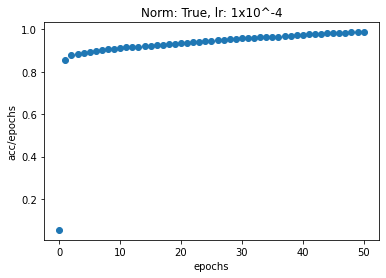

In [87]:
# normalisation: True lr: 4
y = dict_norm_true_4['train_accuracy']
plt.scatter(x, y)
plt.xlabel("epochs")
plt.ylabel("acc/epochs")
plt.title("Norm: True, lr: 1x10^-4")
plt.show()

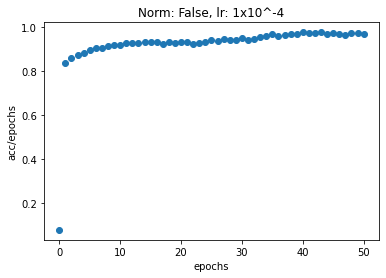

In [88]:
# normalisation: False lr:4
y = dict_norm_false_4['train_accuracy']
plt.xlabel("epochs")
plt.ylabel("acc/epochs")
plt.title("Norm: False, lr: 1x10^-4")
plt.scatter(x, y)
plt.show()

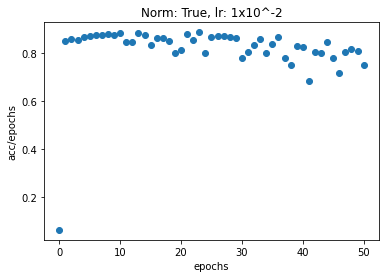

In [89]:
# normalisation: True lr: 2
y = dict_norm_true_2['train_accuracy']
plt.scatter(x, y)
plt.xlabel("epochs")
plt.ylabel("acc/epochs")
plt.title("Norm: True, lr: 1x10^-2")
plt.show()

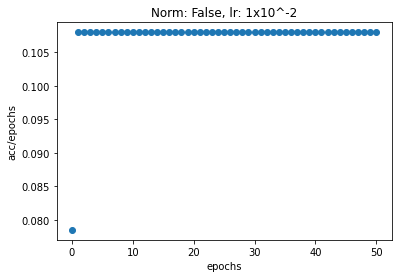

In [90]:
# normalisation: False lr: 2
y = dict_norm_false_2['train_accuracy']
plt.scatter(x, y)
plt.xlabel("epochs")
plt.ylabel("acc/epochs")
plt.title("Norm: False, lr: 1x10^-2")
plt.show()

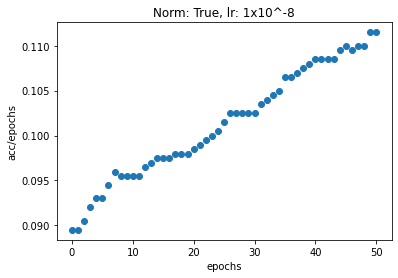

In [91]:
# normalisation: True lr: 8
y = dict_norm_true_8['train_accuracy']
plt.scatter(x, y)
plt.xlabel("epochs")
plt.ylabel("acc/epochs")
plt.title("Norm: True, lr: 1x10^-8")
plt.show()

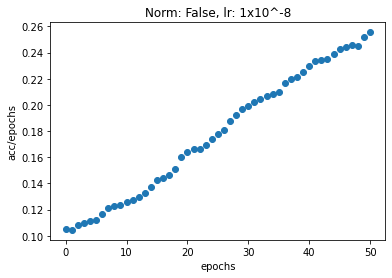

In [93]:
# normalisation: False lr: 8
y = dict_norm_false_8['train_accuracy']
plt.scatter(x, y)
plt.xlabel("epochs")
plt.ylabel("acc/epochs")
plt.title("Norm: False, lr: 1x10^-8")
plt.show()